### DETECT ANOMALIES

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import sys
import os
import pandas as pd
from pathlib import Path

sys.path.append(os.path.abspath(".."))
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.predict_next_month_TC  import call_predict_next_month_total_consumption

In [ ]:
def detect_anomalies(df,poliza_id,threshold):
    total,forecast_df,df_extended= call_predict_next_month_total_consumption(df,poliza_id)

    df_analysis=df_extended.copy()
    #rolling statistics
    df_analysis["rolling_mean"]=df_analysis["CONSUMO_REAL"].rolling(window=7,min_periods=3).mean()
    df_analysis["rolling_std"]=df_analysis["CONSUMO_REAL"].rolling(window=7,min_periods=3).std()
    df_analysis["z_score"]=(df_analysis["CONSUMO_REAL"]-df_analysis["rolling_mean"])/df_analysis["rolling_std"]
    df_analysis["is_anomaly"]=df_analysis["z_score"].abs()>threshold
    anomalies=df_analysis[df_analysis["is_anomaly"]]

    #same with forecasted data
    df_forecasting=forecast_df.copy()
    df_forecasting=df_forecasting.merge(df_analysis[["FECHA","rolling_mean","rolling_std"]],on="FECHA",how="left")
    df_forecasting["forecast_z_score"]=((df_forecasting["CONSUMO_REAL"]-df_forecasting["rolling_mean"])/df_forecasting["rolling_std"])
    df_forecasting["forecast_is_anomaly"]=df_forecasting["forecast_z_score"].abs()>threshold
    anomalies_forecast=df_forecasting[df_forecasting["forecast_is_anomaly"] & df_forecasting["is_forecast"]]

    #overview
    print(f"Detected {len(anomalies)} anomalies for POLIZA {poliza_id}")
    print(f"Detected {len(anomalies_forecast)} forecasted anomalies for POLIZA {poliza_id}")

    #plot
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_analysis, x="FECHA", y="CONSUMO_REAL", label="Historical Consumption")
    sns.scatterplot(data=anomalies, x="FECHA", y="CONSUMO_REAL", color="red", label="Historical Anomaly", s=80)
    sns.lineplot(data=df_forecasting, x="FECHA", y="CONSUMO_REAL", label="Forecasted Consumption", linestyle="--")
    sns.scatterplot(data=anomalies_forecast, x="FECHA", y="CONSUMO_REAL", color="orange", label="Forecast Anomaly", s=80)
    plt.title(f"Consumption anomalies for POLIZA {poliza_id}")
    plt.xlabel("Date")
    plt.ylabel("Real Consumption")
    plt.legend()
    plt.show()
    
    return df_analysis, anomalies, df_forecasting, anomalies_forecast

In [ ]:
file ="clean_incidencies_comptadors_intelligents.parquet"
data_dir = "../data/"

sample_path=os.path.join(data_dir,f"{file}")

df_ICI=pd.read_parquet(sample_path)

In [22]:
df_ICI["POLIZA_SUMINISTRO"].unique()

array(['VECWAVDUULZDSBOP', 'DA43Z5V3WLWLGK5G', '3K3JZBIMMK4BTQB3', ...,
       'TZKK4KKZ5EI63GRS', 'D5OOVNH2X4D4BWQS', 'SZPMTJ7SXUODUNPY'],
      shape=(11797,), dtype=object)

Detected 13 anomalies for POLIZA 3K3JZBIMMK4BTQB3
Detected 0 forecasted anomalies for POLIZA 3K3JZBIMMK4BTQB3


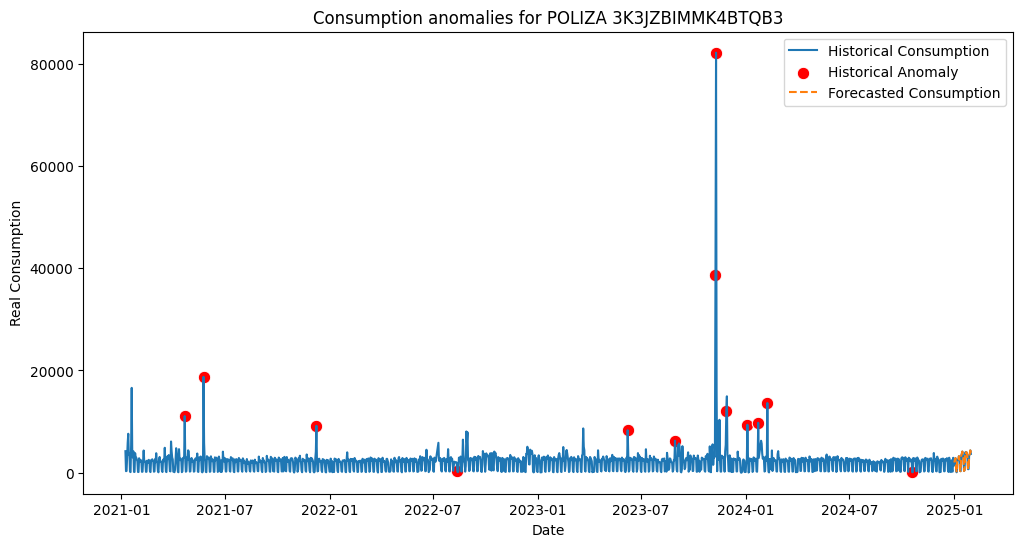

,POLIZA_SUMINISTRO,FECHA,CONSUMO_REAL,year,month,day,dayofweek,lag_1,lag_7,rolling_mean_7,is_forecast,rolling_mean,rolling_std,z_score,is_anomaly
579,3K3JZBIMMK4BTQB3,2022-08-13,339.0,2022,8,13,5,2013.0,396.0,1741.285714,False,1733.142857,658.300698,-2.117790,True
878,3K3JZBIMMK4BTQB3,2023-06-08,8310.0,2023,6,8,3,2210.0,2650.0,1582.571429,False,2391.142857,2848.171368,2.078125,True
961,3K3JZBIMMK4BTQB3,2023-08-30,6266.0,2023,8,30,2,2451.0,2202.0,1693.857143,False,2274.428571,1984.794016,2.011076,True
1032,3K3JZBIMMK4BTQB3,2023-11-09,38657.0,2023,11,9,3,3231.0,2953.0,3505.285714,False,8605.857143,13314.215817,2.257072,True
1033,3K3JZBIMMK4BTQB3,2023-11-10,82135.0,2023,11,10,4,38657.0,4815.0,8605.857143,False,19651.571429,30555.195084,2.044936,True
1051,3K3JZBIMMK4BTQB3,2023-11-28,12009.0,2023,11,28,1,5441.0,2907.0,3081.571429,False,4381.857143,3719.006248,2.050855,True
1088,3K3JZBIMMK4BTQB3,2024-01-04,9383.0,2024,1,4,3,2578.0,2599.0,1490.285714,False,2459.428571,3264.773900,2.120689,True
1107,3K3JZBIMMK4BTQB3,2024-01-23,9766.0,2024,1,23,1,3129.0,2324.0,1978.142857,False,3041.285714,3203.777547,2.098995,True
1120,3K3JZBIMMK4BTQB3,2024-02-08,13635.0,2024,2,8,3,2296.0,3043.0,1997.428571,False,3510.571429,4604.917041,2.198613,True
1374,3K3JZBIMMK4BTQB3,2024-10-19,135.0,2024,10,19,5,2558.0,173.0,2276.428571,False,2271.000000,970.633642,-2.200624,True


,0,1,2,3,4,5,6,7,8,9,...,POLIZA_SUMINISTRO,day,dayofweek,forecast_is_anomaly,forecast_z_score,is_forecast,month,rolling_mean,rolling_std,year


In [ ]:
df_analysis,anomalies, df_forecasting, anomalies_forecast=detect_anomalies(df_ICI,"3K3JZBIMMK4BTQB3",threshold=2)
display(anomalies.tail(10))
display(anomalies_forecast.tail(10))